# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. 

El objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, se utilizará un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [82]:
#Cargamos las librerias
import math
import re

import numpy as np
import pandas as pd
import nltk
import spacy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

In [83]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [84]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [85]:
#cargamos los datos
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [86]:
#mostramos la informacion del dataframe
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [87]:
#mostramos las primeras filas 
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [88]:
#validamos si tenemos duplicados
print(df_reviews.duplicated().sum())

0


In [89]:
#validamos si tenemos valores ausentes
print(df_reviews.isna().sum())

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64


In [90]:
#Se eliminan los valores ausentes de las columnas 'average_rating' y 'votes'
df_reviews.dropna(inplace=True)

In [91]:
# se valida nuevamente los cambios realizados
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47329 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47329 non-null  object 
 1   title_type       47329 non-null  object 
 2   primary_title    47329 non-null  object 
 3   original_title   47329 non-null  object 
 4   start_year       47329 non-null  int64  
 5   end_year         47329 non-null  object 
 6   runtime_minutes  47329 non-null  object 
 7   is_adult         47329 non-null  int64  
 8   genres           47329 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47329 non-null  object 
 12  rating           47329 non-null  int64  
 13  sp               47329 non-null  object 
 14  pos              47329 non-null  int64  
 15  ds_part          47329 non-null  object 
 16  idx              47329 non-null  int64  
dtypes: Int64(1),

## EDA

### Películas y reseñas a lo largo de los años.

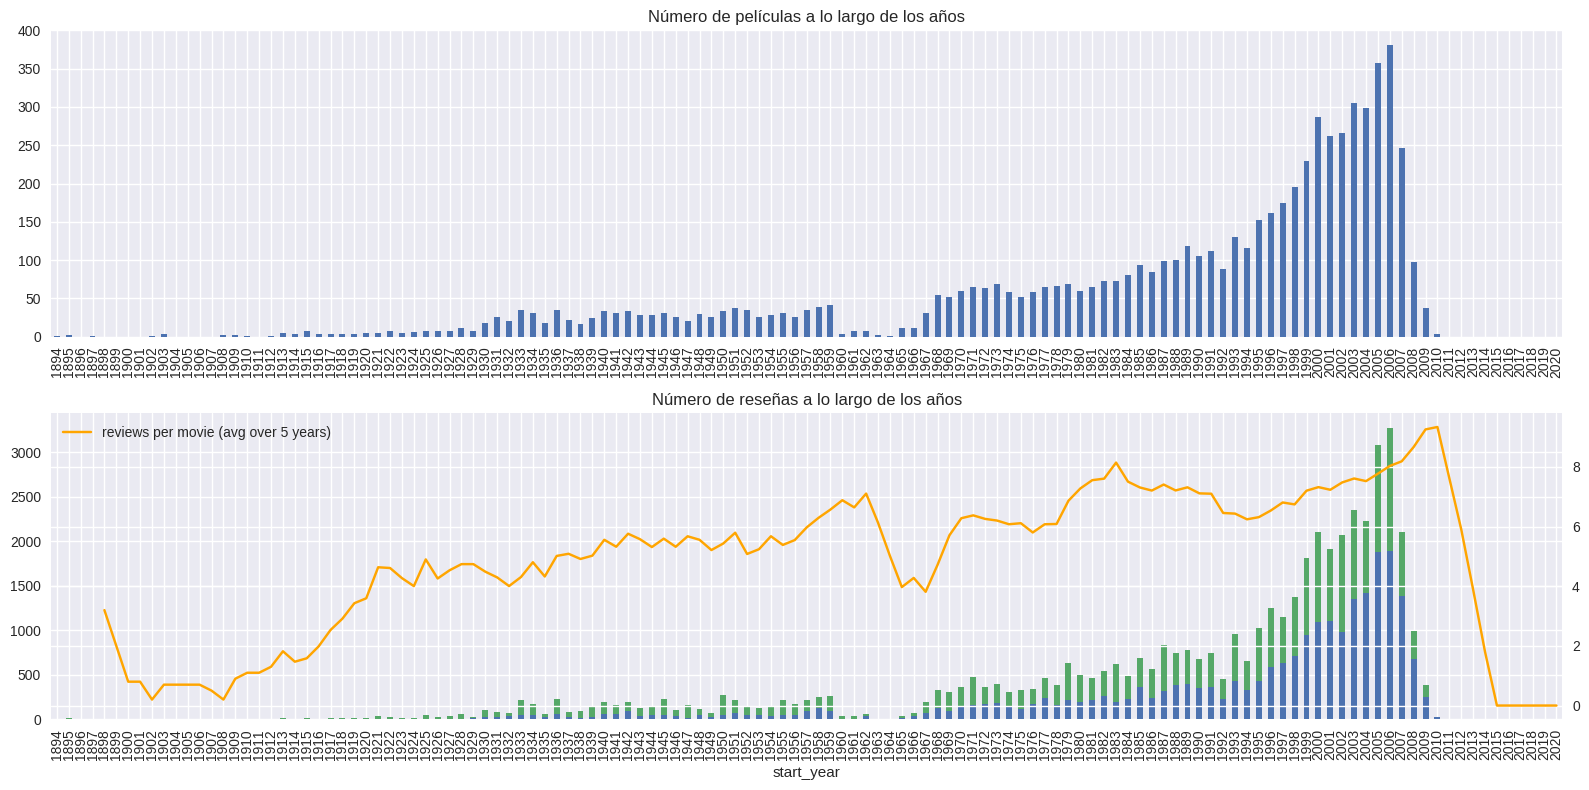

In [92]:
# graficamos el número de películas y reseñas a lo largo de los años.
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Se observa un crecimiento constante en el número de películas estrenadas entre 1920 y 1959. Sin embargo, a partir de 1960, comienza un periodo de descenso en la producción de peliculas.A partir de 1967, se experimenta una nueva fase de crecimiento, alcanzando su pico máximo en 2006. Después de 2006, se aprecia una disminución drástica en el número de películas estrenadas, con una tendencia a la baja que continúa hasta la fecha.

El comportamiento del número de reseñas sigue una tendencia similar a la de las películas, con un aumento notable en las reseñas a lo largo del tiempo.
Inicialmente, se observa una ligera predominancia de reseñas positivas sobre las negativas. Sin embargo, a partir de 1997, las reseñas negativas comienzan a superar a las positivas, marcando un posible cambio del público hacia las películas.


### Distribución del número de reseñas por película

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

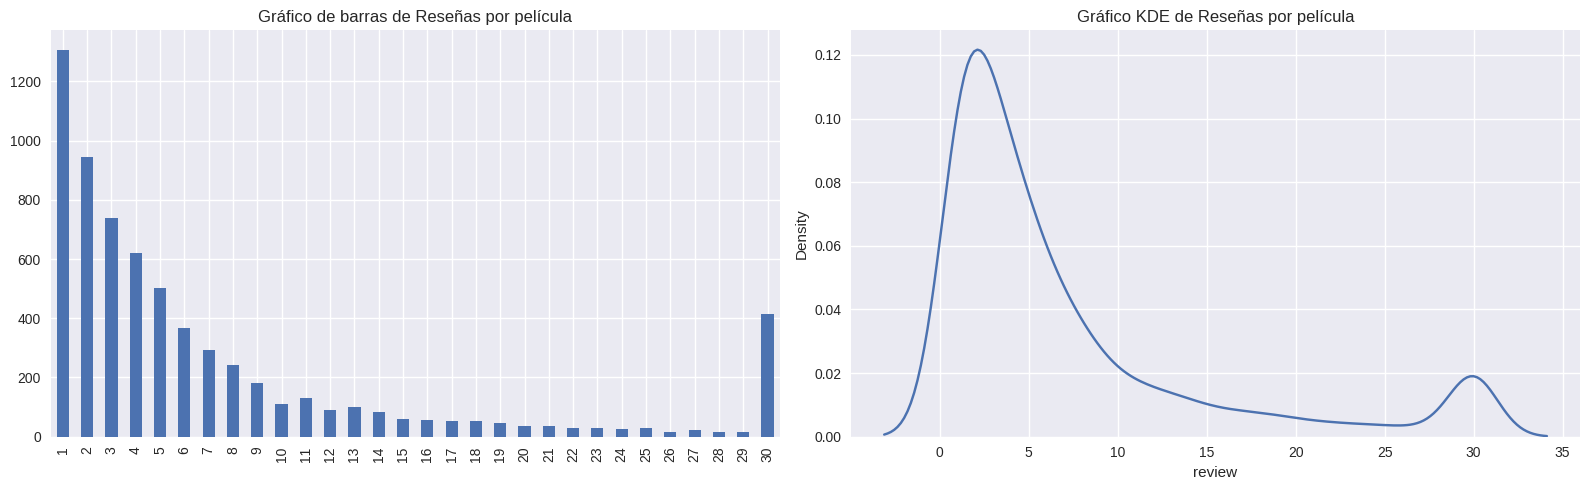

In [93]:
#distribución del número de reseñas por película con el conteo exacto y KDE 
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de Reseñas por película')

fig.tight_layout()

La mayoría de las películas tienen solo una reseña. A medida que aumenta el número de reseñas por película, la cantidad de películas que tienen ese número de reseñas disminuye. Sin embargo, se destaca un gran número de películas que tienen 30 reseñas, lo que indicaría que hay un grupo de películas con una cantidad considerable de interacción por parte de los usuarios.


### Distribución de puntuaciones

In [94]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

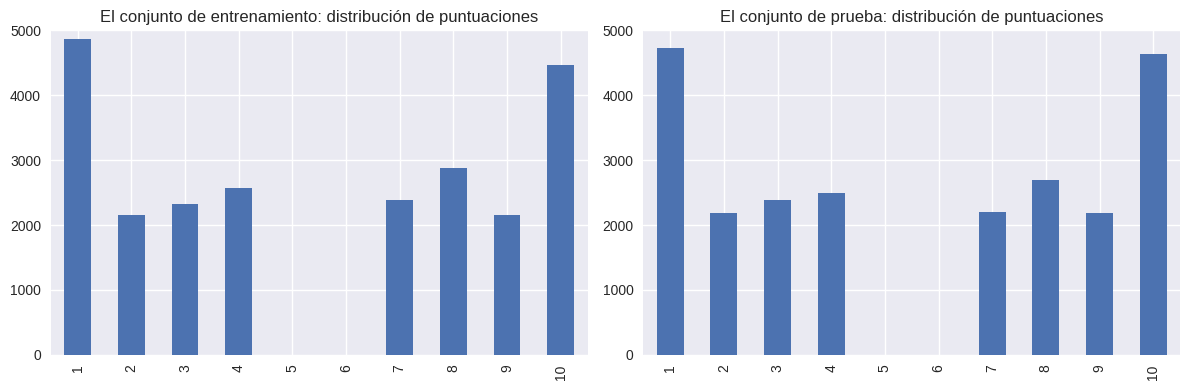

In [95]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Las películas reciben en su mayoría puntuaciones extremas (muy bajas o muy altas), con una menor cantidad de puntuaciones intermedias.

En general, las puntuaciones más altas (9 y 10) parecen estar tan distribuidas como las más bajas (1 y 2), con algunas pocas películas recibiendo puntuaciones más equilibradas.

no hay puntuaciones de 5 o 6, lo que sugiere que los usuarios no suelen calificar las películas de manera neutral o ligeramente positiva.

La distribución de puntuaciones en los conjuntos de entrenamiento y prueba es casi idéntica, lo que sugiere que ambos conjuntos de datos son similares en términos de las calificaciones que las películas reciben.

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

### Distribución de reseñas a lo largo de los años en el conjunto de entrenamiento y prueba

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


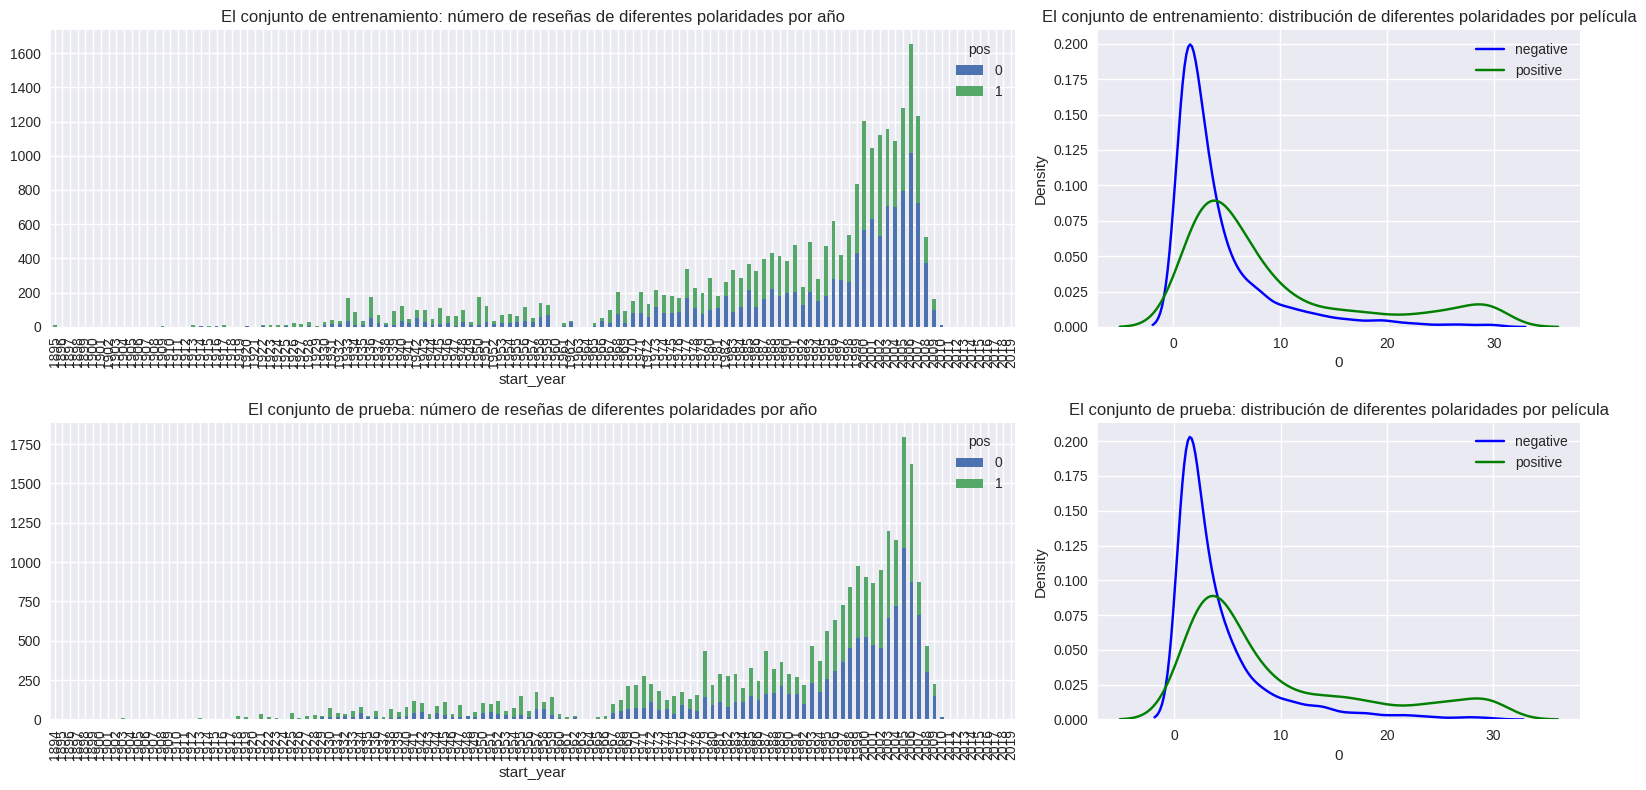

In [96]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

Las gráficas muestran un comportamiento muy similar entre el conjunto de entrenamiento y el conjunto de prueba. En ambos casos, se observa una tendencia mayor de reseñas negativas en comparación con las positivas. Esta tendencia se refleja tanto en la distribución de reseñas por año, donde las reseñas negativas suelen ser un poco más numerosas, como en la distribución por película, donde las reseñas negativas también son más frecuentes que las positivas a lo largo del tiempo.

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [97]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [98]:
# Hacemos una función para normalizar textos
def normalize_text(text):
    # Convierte a minúsculas, elimina dígitos, puntuaciones y espacios adicionales
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Aplicar normalización a la columna 'review'
df_reviews['review_norm'] = df_reviews['review'].progress_apply(normalize_text)

  0%|          | 0/47329 [00:00<?, ?it/s]

In [99]:
# Verificamos las primeras filas de la columna normalizada
df_reviews[['review', 'review_norm']].head()

,review,review_norm
0,The pakage implies that Warren Beatty and Gold...,the pakage implies that warren beatty and gold...
1,How the hell did they get this made?! Presenti...,how the hell did they get this made presenting...
2,There is no real story the film seems more lik...,there is no real story the film seems more lik...
3,Um .... a serious film about troubled teens in...,um a serious film about troubled teens in sing...
4,I'm totally agree with GarryJohal from Singapo...,im totally agree with garryjohal from singapor...


In [100]:
# Ver distribución de clases
class_distribution = df_reviews['pos'].value_counts(normalize=True)
print("Distribución de clases (0=Negativa, 1=Positiva):")
print(class_distribution)

Distribución de clases (0=Negativa, 1=Positiva):
0    0.501067
1    0.498933
Name: pos, dtype: float64


Las clases están prácticamente equilibradas. La diferencia en las proporciones es mínima, lo que significa que tanto las reseñas positivas como las negativas están muy bien distribuidas en tu conjunto de datos.

## División entrenamiento / prueba

todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [101]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


## Trabajar con modelos

### Modelo 0 - Constante

In [102]:
# Establecer el lematizador
lemmatizer = WordNetLemmatizer()

# Fijar palabras vacías
stop_words = set(stopwords.words('english'))

# Función para lematizar
def lem_nltk(df_column, lemmatizer, stop_words):
    lemmatized_reviews = []
    for review in df_column:
        # Tokenizar
        tokens = word_tokenize(review)
        
        # Eliminar palabras vacías
        tokens_stop = [token for token in tokens if token not in stop_words]
        
        # Lematizar tokens sin palabras vacías
        lemmas = [lemmatizer.lemmatize(token) for token in tokens_stop]
        lemmas_joined = " ".join(lemmas)
        lemmatized_reviews.append(lemmas_joined)
        
    return lemmatized_reviews

In [103]:
# Aplicar la lematización
train_features0 = lem_nltk(df_reviews_train['review_norm'], lemmatizer, stop_words)
test_features0 = lem_nltk(df_reviews_test['review_norm'], lemmatizer, stop_words)

# Vectorizar el texto lematizado
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_features0)
X_test = vectorizer.transform(test_features0)

           train  test
Exactitud    NaN   NaN
F1           0.0   0.0
APS          0.5   0.5
ROC AUC      0.5   0.5


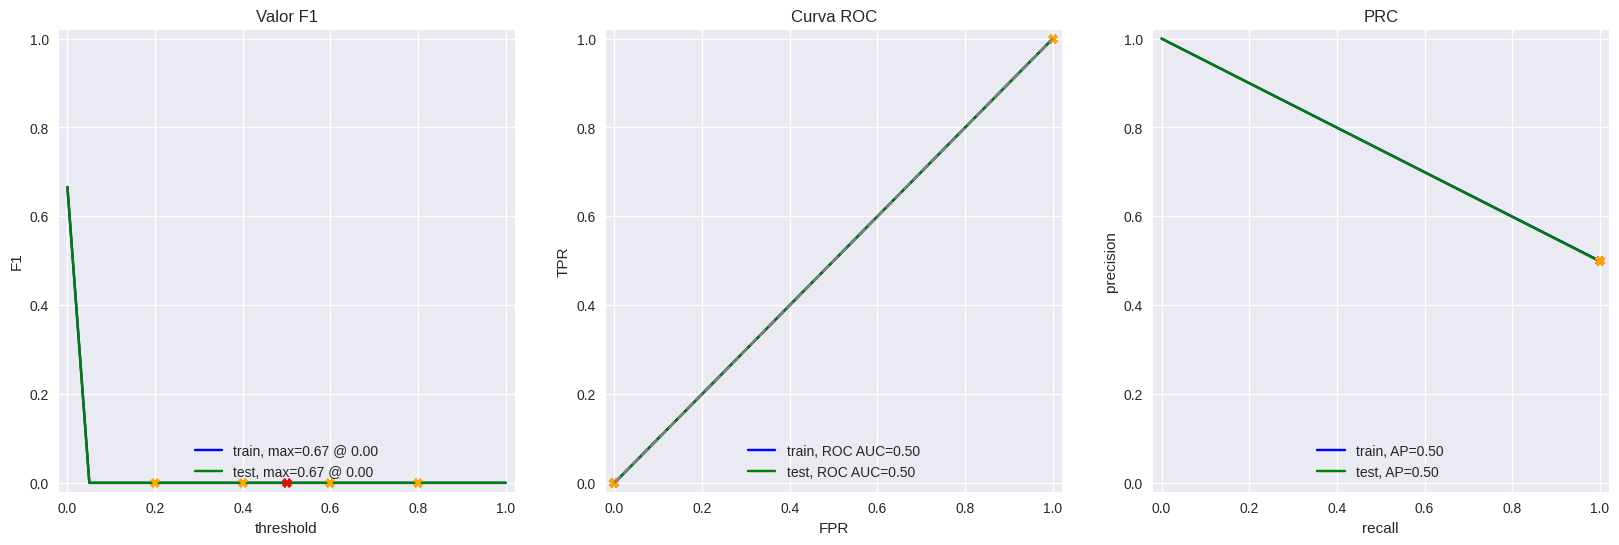

In [104]:
# Crear y entrenar el modelo Dummy
model_0 = DummyClassifier(strategy='most_frequent')
model_0.fit(X_train, train_target)

# Evaluar el modelo
evaluate_model(model_0, X_train, train_target, X_test, test_target)

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [105]:
# Vectorización TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=5000)
train_features_1 = tfidf_vectorizer.fit_transform(df_reviews_train['review_norm'])
test_features_1 = tfidf_vectorizer.transform(df_reviews_test['review_norm'])


In [106]:
# Modelo de regresión logística
model_1 = LogisticRegression(random_state=12345, max_iter=500)
model_1.fit(train_features_1, train_target)

LogisticRegression(max_iter=500, random_state=12345)

           train  test
Exactitud    NaN   NaN
F1          0.92  0.88
APS         0.97  0.95
ROC AUC     0.97  0.95


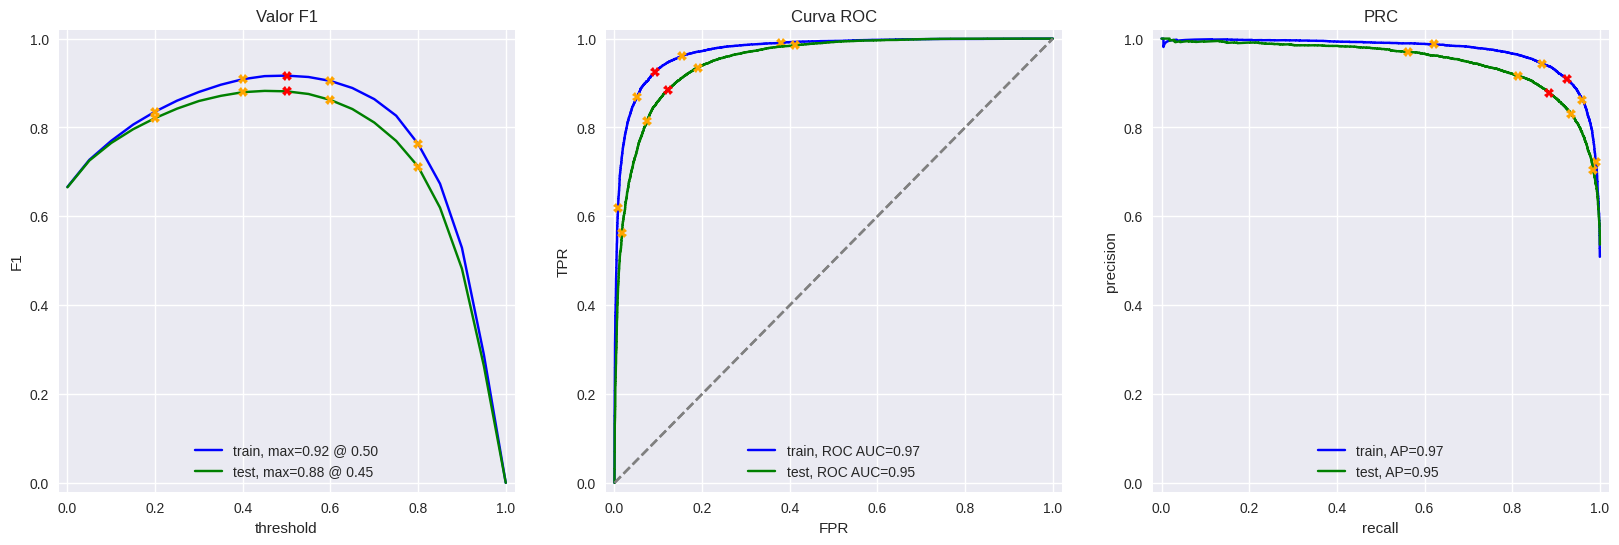

In [107]:
# Evaluación
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

se evidencia que todas las métricas son mejores a las del modelo dummy y se cumple que el valor F1 es mayor a 0.85.

### Modelo 2 - spaCy, TF-IDF y LR

In [108]:
# Se carga el modelo preentrenado para inglés y deshabilitar algunos componentes
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

  0%|          | 0/23796 [00:00<?, ?it/s]

  0%|          | 0/23533 [00:00<?, ?it/s]

           train  test
Exactitud    NaN   NaN
F1          0.91  0.87
APS         0.97  0.94
ROC AUC     0.97  0.95


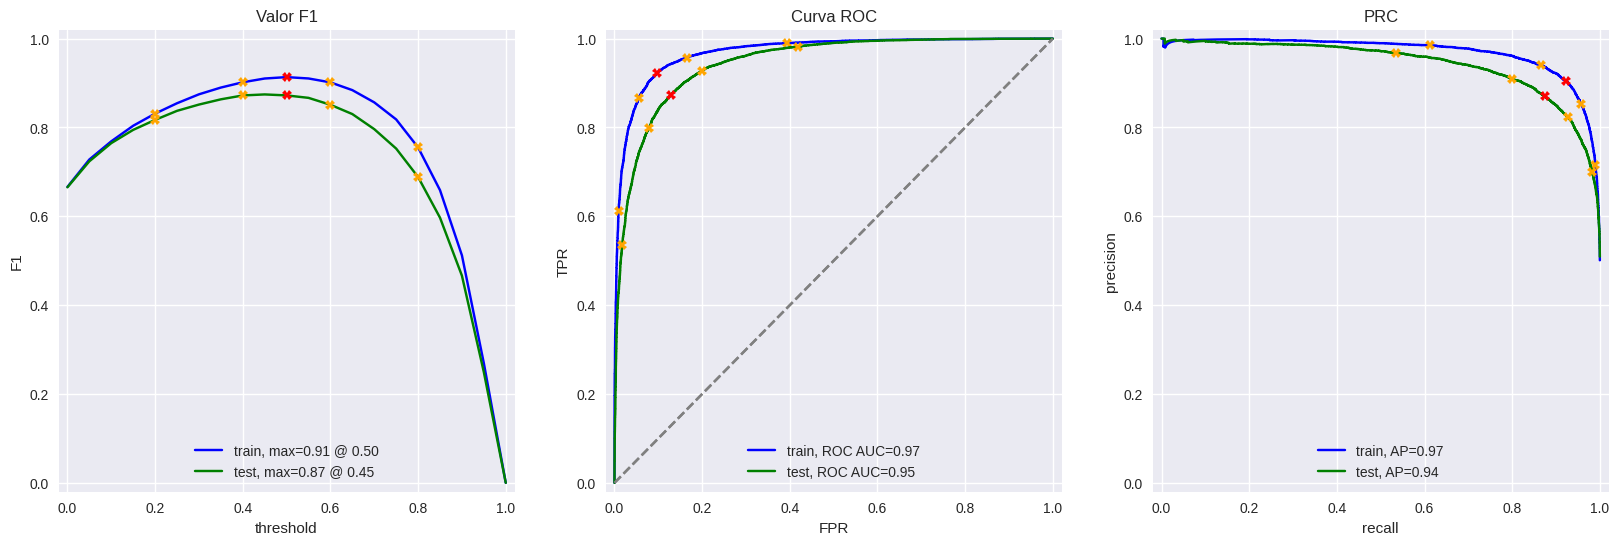

In [109]:
# Establecer la funcion para lematizar con SpaCy
def lemmatize_text(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    
    return ' '.join(tokens)

df_reviews_train['review_lemma'] = df_reviews_train['review_norm'].progress_apply(lemmatize_text)
df_reviews_test['review_lemma'] = df_reviews_test['review_norm'].progress_apply(lemmatize_text)

# Vectorización con TF-IDF
tfidf_vectorizer_2 = TfidfVectorizer(max_features=5000)

train_features_2 = tfidf_vectorizer_2.fit_transform(df_reviews_train['review_lemma'])
test_features_2 = tfidf_vectorizer_2.transform(df_reviews_test['review_lemma'])

# Modelo de regresión logística
model_2 = LogisticRegression(random_state=12345, max_iter=500)
model_2.fit(train_features_2, train_target)

# Evaluación
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

Se evidencia valores altos en todas las metricas del modelo 2, sin embargo, el modelo 1 presenta valores ligeramente mas altos.

### Modelo 3 - spaCy, TF-IDF y LGBMClassifier

In [110]:
# # Usar GridSearchCV para buscar los mejores hiperparámetros
param_grid_lgbm = {
    'n_estimators': [10, 20, 50],
    'learning_rate': [0.5, 0.1],
    'num_leaves': [10, 15, 20],
    'objective': ['binary'],
    'random_state': [12345] 
}

grid_search = GridSearchCV(estimator=LGBMClassifier(), param_grid=param_grid_lgbm,
                           scoring='f1', cv=3, n_jobs=-1, verbose=0)

# Ajustar el modelo con los datos de entrenamiento
grid_search.fit(train_features_2, train_target) 

GridSearchCV(cv=3, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.5, 0.1],
                         'n_estimators': [10, 20, 50],
                         'num_leaves': [10, 15, 20], 'objective': ['binary'],
                         'random_state': [12345]},
             scoring='f1')

In [111]:
# El mejor modelo con los mejores parámetros
model_3 = grid_search.best_estimator_

           train  test
Exactitud    NaN   NaN
F1          0.93  0.85
APS         0.98  0.93
ROC AUC     0.98  0.93


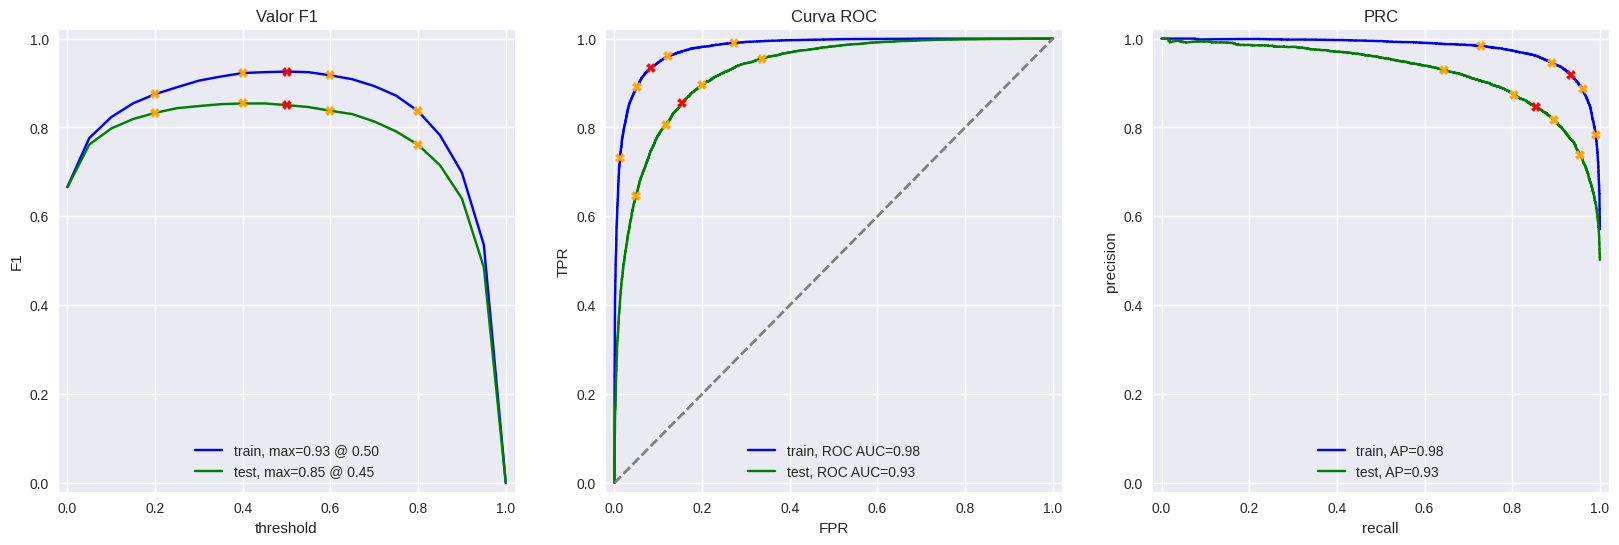

In [112]:
# Evaluar el modelo usando la función 'evaluate_model'
evaluate_model(model_3, train_features_2, train_target, test_features_2, test_target)

vemos que el modelo 3 que en el conjunto de entrenamiento presentar valores mas altos en las metricas que los otros dos modelos, sin embargo en el conjunto de prueba los valores son ligeramente mas bajos que los modelos 1 y 2.

## Mis reseñas

Se tomaran nuevas reseñas para probar los modelos mostrados previamente.

In [113]:
# Nuevas reseñas 

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""


"\nmy_reviews = pd.DataFrame([\n    'Simplemente no me gustó, no es mi tipo de película.',\n    'Bueno, estaba aburrido y me quedé dormido a media película.',\n    'Estaba realmente fascinada con la película',    \n    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',\n    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',\n    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',\n    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',\n    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'\n], columns=['review'])\n"

In [114]:
# Normalizamos las reseñas personales
my_reviews['review_norm'] = my_reviews['review'].progress_apply(normalize_text)
my_reviews

  0%|          | 0/8 [00:00<?, ?it/s]

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


se evidencia que las peliculas con reseñas positivas son las de indice: 2, 4, 5 y 7 y las de reseñas negativas las de indice: 0, 1, 3 y 6

### Modelo 1

In [115]:
texts = my_reviews['review_norm']

# Generamos predicciones
my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer.transform(texts))[:, 1]

# Mostramos resultados
print("\nResultados Modelo 1 ( NLTK, TF-IDF) - Logistic Regression:")
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')


Resultados Modelo 1 ( NLTK, TF-IDF) - Logistic Regression:
0.19:  i did not simply like it not my kind of movie
0.16:  well i was bored and felt asleep in the middle of the movie
0.60:  i was really fascinated with the movie
0.10:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.21:  i didnt expect the reboot to be so good writers really cared about the source material
0.54:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.05:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.91:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


En el modelo 1 las respuestas cercanas a 0 indican una reseña negativa (0.05, 0.10) y las respuestas cercanas a 1 indican una reseña positiva (0.91, 0.60). La reseña con 0.54 es ambigua, lo que refleja una percepción moderada.

### Modelo 2

In [116]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts.progress_apply(lambda x: lemmatize_text(x))))[:, 1]

# Mostramos resultados
print("\nResultados Modelo 2 - spaCy + Logistic Regression:")
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

  0%|          | 0/8 [00:00<?, ?it/s]


Resultados Modelo 2 - spaCy + Logistic Regression:
0.22:  i did not simply like it not my kind of movie
0.07:  well i was bored and felt asleep in the middle of the movie
0.44:  i was really fascinated with the movie
0.12:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.13:  i didnt expect the reboot to be so good writers really cared about the source material
0.37:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.95:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


El modelo 2 predice reseñas negativas con mayor seguridad (0.07 y 0.04 para reseñas claramente negativas).
Sin embargo, no es tan seguro con las reseñas positivas (0.44, 0.37)

### Modelo 3

In [117]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_2.transform(texts.progress_apply(lambda x: lemmatize_text(x))))[:, 1]

# Mostramos resultados
print("\nResultados Modelo 3 - spaCy + LightGBMClassifier:")
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

  0%|          | 0/8 [00:00<?, ?it/s]


Resultados Modelo 3 - spaCy + LightGBMClassifier:
0.63:  i did not simply like it not my kind of movie
0.22:  well i was bored and felt asleep in the middle of the movie
0.66:  i was really fascinated with the movie
0.44:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.24:  i didnt expect the reboot to be so good writers really cared about the source material
0.57:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.23:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.88:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


El modelo 3 parece tener una mayor tendencia a predecir probabilidades intermedias (ej.: 0.63, 0.44, 0.57). No tiene tanta confianza para reseñas negativas comparado con los otros dos modelos.

## Conclusiones

Los modelos basados en Logistic Regression (Modelos 1 y 2) tienen el mejor equilibrio entre F1 y métricas relacionadas,
LightGBM (Modelo 3) tiene un desempeño ligeramente inferior pero sigue siendo robusto.

Para reseñas claramente positivas (indice 7) o negativas (indice 6), los modelos tienden a coincidir en sus predicciones, aunque el Modelo 1 (NLTK, TF-IDF) y el Modelo 2 (spaCy, TF-IDF) muestran una mayor confianza.

El Modelo 1 (Logistic Regression con NLTK, TF-IDF) se posiciona como el más adecuado, logrando un F1 de 0.88 en el conjunto de prueba y un buen rendimiento en las reseñas personales. Su confianza en reseñas extremas lo hace ideal para lo que se busca.

El modelo 1 replica su rendimiento en reseñas personales, lo que valida su capacidad de generalización.

por lo anterior, se recomienda usar el Modelo 1 como base para la implementación del sistema de clasificación en Film Junky Union.